Nifty tutorial for 2D dust
=====================================

Setup
-----

In [1]:
#!/usr/bin/env python3

# Copyright(C) 2013-2021 Max-Planck-Society
# SPDX-License-Identifier: GPL-2.0+ OR BSD-2-Clause

# %% [markdown]
# # 3D Tomography Example with known start- and end-points

# %%

import jax
import matplotlib.pyplot as plt
import nifty8.re as jft
import numpy as np
from jax import numpy as jnp
from jax import random

jax.config.update("jax_enable_x64", True)

# %%
key = random.PRNGKey(1)

dims = (128, 128)
distances = tuple(1.0 / d for d in dims)






Initialzing the field model
---------------------------

In [2]:
cfm = jft.CorrelatedFieldMaker("cf")
cfm.set_amplitude_total_offset(offset_mean=2, offset_std=(1e-1, 3e-2))
cfm.add_fluctuations(  # Axis over which the kernle is defined
    dims,
    distances=distances,
    fluctuations=(1.0, 5e-1),
    loglogavgslope=(-5.0, 2e-1),
    flexibility=(1e0, 2e-1),
    asperity=(5e-1, 5e-2),
    prefix="ax1",
    non_parametric_kind="power",
)
correlated_field = cfm.finalize()  # forward model for a GP prior


Draw synthetic end points and initialize the repository
-------------------------------------------------------

In [3]:
# %%
# 
n_synth_points = 100
key, sk = random.split(key)
end = random.uniform(
    sk,
    (n_synth_points, len(dims)),
    minval=0.05,
    maxval=0.95,
)

# %%
start = (0.5, 0.5)
n_sampling_points = 256
los = jft.SamplingCartesianGridLOS(
    start,
    end,
    distances=distances,
    shape=correlated_field.target.shape,
    dtype=correlated_field.target.dtype,
    n_sampling_points=n_sampling_points,
)

Build forward model
-------------------

In [4]:
class Forward(jft.Model):
    def __init__(self, log_density, los):
        self.log_density = log_density
        self.los = los
        # Track a method with which a random input for the model. This is not
        # strictly required but is usually handy when building deep models.
        super().__init__(init=log_density.init)

    def density(self, x):
        return jnp.exp(self.log_density(x))

    def __call__(self, x):
        return self.los(self.density(x))


forward = Forward(correlated_field, los)

Draw synthetic data
-------------------

In [5]:
# %%
key, k_f, k_n = random.split(key, 3)
synth_pos = forward.init(k_f)
synth_truth = forward(synth_pos)
noise_scl = 0.15
synth_noise = random.normal(k_n, synth_truth.shape, synth_truth.dtype)
synth_noise = synth_noise * noise_scl * synth_truth
synth_data = synth_truth + synth_noise


The likelihood
--------------

In [6]:
lh = jft.Gaussian(synth_data, noise_cov_inv=1.0 / synth_noise**2).amend(forward)

assuming the specified inverse covariance is diagonal
assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


The inference
-------------

In [7]:
# %%
n_vi_iterations = 6
delta = 1e-4
n_samples = 4

key, k_i, k_o = random.split(key, 3)
samples, state = jft.optimize_kl(
    lh,
    jft.Vector(lh.init(k_i)),
    n_total_iterations=n_vi_iterations,
    n_samples=lambda i: n_samples // 2 if i < 2 else n_samples,
    key=k_o,
    draw_linear_kwargs=dict(
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=100),
    ),
    nonlinearly_update_kwargs=dict(
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict(
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name="MCG"), maxiter=35
        )
    ),
    sample_mode="linear_resample",
    odir="results_tomography",
    resume=False,
)

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+9.2681e+04 Δ⛰:inf ➽:1.9627e-01
SL: Iteration 1 ⛰:+2.2366e+04 Δ⛰:7.0315e+04 ➽:1.9627e-01
SL: Iteration 2 ⛰:+1.5245e+04 Δ⛰:7.1219e+03 ➽:1.9627e-01
SL: Iteration 3 ⛰:-1.9008e+03 Δ⛰:1.7145e+04 ➽:1.9627e-01
SL: Iteration 4 ⛰:-8.4163e+03 Δ⛰:6.5155e+03 ➽:1.9627e-01
SL: Iteration 5 ⛰:-9.0194e+03 Δ⛰:6.0310e+02 ➽:1.9627e-01
SL: Iteration 6 ⛰:-9.3168e+03 Δ⛰:2.9746e+02 ➽:1.9627e-01
SL: Iteration 7 ⛰:-9.7920e+03 Δ⛰:4.7522e+02 ➽:1.9627e-01
SL: Iteration 8 ⛰:-9.9023e+03 Δ⛰:1.1022e+02 ➽:1.9627e-01
SL: Iteration 9 ⛰:-9.9681e+03 Δ⛰:6.5791e+01 ➽:1.9627e-01
SL: Iteration 10 ⛰:-9.9692e+03 Δ⛰:1.1275e+00 ➽:1.9627e-01
SL: Iteration 11 ⛰:-1.0001e+04 Δ⛰:3.2295e+01 ➽:1.9627e-01
SL: Iteration 12 ⛰:-1.0002e+04 Δ⛰:6.0198e-01 ➽:1.9627e-01
SL: Iteration 13 ⛰:-1.0018e+04 Δ⛰:1.5754e+01 ➽:1.9627e-01
SL: Iteration 14 ⛰:-1.0024e+04 Δ⛰:6.3677e+00 ➽:1.9627e-01
SL: Iteration 15 ⛰:-1.0024e+04 Δ⛰:1.3805e-01 ➽:1.9627e-01
SL: Iteration 0 ⛰:+7.6420e+04 Δ⛰:inf ➽:1.9627e-01
SL: Iteratio

Plot posterior
--------------

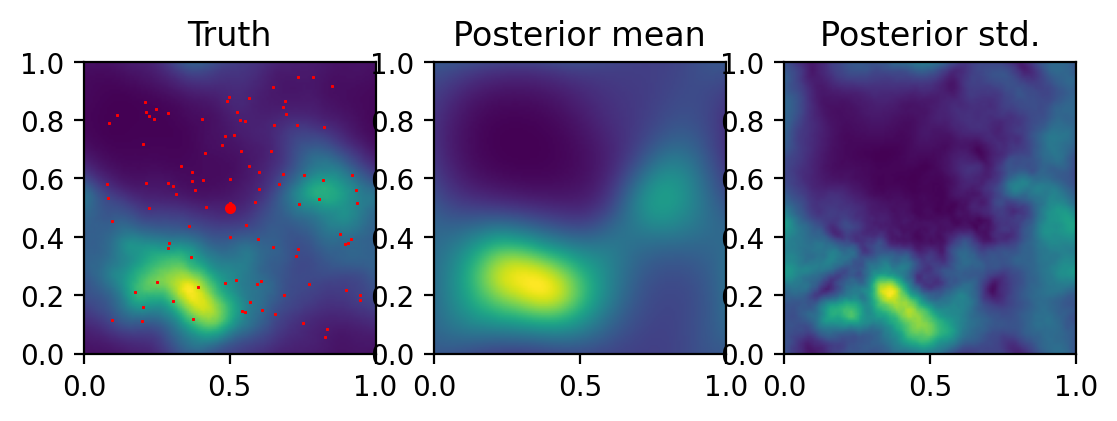

In [10]:


# %%
synth_density = forward.density(synth_pos)
post_density = jax.vmap(forward.density)(samples.samples)

# %%
extent = (0, 1, 0, 1)
fig, axs = plt.subplots(1, 3, dpi=200)
ax_t, ax_p, ax_ps = axs
ax_t.imshow(synth_density, extent=extent)
ax_t.plot(
    *end[:].T,
    "+",
    markersize=0.5,
    color="red",
)
ax_t.plot(
    *start,
    ".",
    markersize=6,
    color="red",
)
ax_p.imshow(post_density.mean(axis=0), extent=extent)
ax_ps.imshow(post_density.std(axis=0), extent=extent)
for title, ax in zip(("Truth", "Posterior mean", "Posterior std."), axs):
    ax.set_title(title)
fig.savefig("results_tomography_projected_full_reconstruction.png", dpi=300)
plt.show()